In [249]:
# Parameters
MESH_DENSITY = 15
TIME_STEP_LENGTH = 0.01
N_TIME_STEPS = 300

INLET_VELOCITY = 1.0 # m/s

# Fluid properties
DENSITY = 1 # kg/m^3
VISCOSITY =  0.01#8.9 * 10**-4 #0.01 # Pa*s
THERMAL_CONDUCTIVITY = 0.1 #0.606 # W/(m * K)
SPECIFIC_HEAT_CAPACITY =  1 #4180.0 # J/(kg * K)

print('Nu',round(VISCOSITY/DENSITY,4)) # Kinematic Viscosity
print('Kappa',round(THERMAL_CONDUCTIVITY/(DENSITY*SPECIFIC_HEAT_CAPACITY),5)) # Thermal diffusivity


Nu 0.01
Kappa 0.1


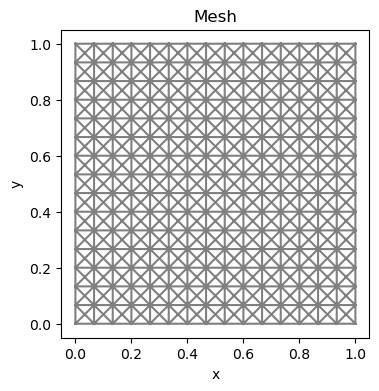

900


In [250]:
import fenics as fe
import mshr as ms
import matplotlib.pyplot as plt

# Create the mesh
box = ms.Rectangle(fe.Point(0.0, 0.0), fe.Point(1.0, 1.0))
hole = ms.Rectangle(fe.Point(0.2,0.4),fe.Point(0.8,0.6)) # 

domain = box 
# domain -= ms.Rectangle(fe.Point(0.4,0.6),fe.Point(0.6,1.1))
# domain -= ms.Rectangle(fe.Point(0.4,-0.1),fe.Point(0.6,0.4))

mesh = ms.generate_mesh(domain, MESH_DENSITY)
# mesh = fe.UnitSquareMesh(MESH_DENSITY,MESH_DENSITY,'crossed')
# mesh = fe.Mesh('./snake_hole.xml')
mesh = fe.UnitSquareMesh(MESH_DENSITY,MESH_DENSITY,'crossed')
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('x')
ax.set_ylabel('y')
fe.plot(mesh, title='Mesh')
plt.show()

print(mesh.num_cells())

In [251]:
# Define the function spaces

# Taylor-Hood Elements. The order of the function space for the pressure has
# to be one order lower than for the velocity
velocity_function_space = fe.VectorFunctionSpace(mesh, "Lagrange", 2)
pressure_function_space = fe.FunctionSpace(mesh, "Lagrange", 1)


# Define the trial and test functions
u = fe.TrialFunction(velocity_function_space)
p = fe.TrialFunction(pressure_function_space)
v = fe.TestFunction(velocity_function_space)
q = fe.TestFunction(pressure_function_space)

# Heat eq
heat_function_space = fe.FunctionSpace(mesh,'Lagrange', 1)
t = fe.TrialFunction(heat_function_space)
w = fe.TestFunction(heat_function_space)

In [252]:
# Define the Boundary Condition
def top_boundary(x, on_boundary): return on_boundary and fe.near(x[1], 1.0)
def bottom_boundary(x, on_boundary): return on_boundary and fe.near(x[1], 0.0)
def left_boundary(x, on_boundary): return on_boundary and fe.near(x[0], 0.0)
def right_boundary(x, on_boundary): return on_boundary and fe.near(x[0], 1.0)

inflow_sin = fe.Expression(('0.33 * (sin(2*pi*x[0]) + 1)', 0.0), degree=2)
inflow_exp = fe.Expression(('exp(0.5*x[0])-1','pow(sin(2*pi*x[1]),2)'),degree = 2)
inflow = fe.Constant((INLET_VELOCITY, 0.0))
noslip = fe.Constant((0.0, 0.0))

velocity_boundary_conditions = [
    fe.DirichletBC(velocity_function_space, noslip, left_boundary),
    fe.DirichletBC(velocity_function_space, noslip, right_boundary),
    fe.DirichletBC(velocity_function_space, inflow, top_boundary),
    fe.DirichletBC(velocity_function_space, noslip, bottom_boundary),
]

pressure_boundary_conditions = [
    fe.DirichletBC(pressure_function_space, 0.0, left_boundary),
    fe.DirichletBC(pressure_function_space, 0.0, right_boundary),
    fe.DirichletBC(pressure_function_space, 0.0, top_boundary),
    fe.DirichletBC(pressure_function_space, 0.0, bottom_boundary)
]

heat_boundary_conditions = [
    fe.DirichletBC(heat_function_space, 150.0, left_boundary),
    fe.DirichletBC(heat_function_space, 0.0, right_boundary),
    fe.DirichletBC(heat_function_space, 0.0, top_boundary),
    fe.DirichletBC(heat_function_space, 0.0, bottom_boundary)
]


In [253]:
# Define the solution fields involved
u_prev = fe.Function(velocity_function_space) # velocity at previous time step, used for time integration
u_tent = fe.Function(velocity_function_space) # velocity before pressure correction
u_next = fe.Function(velocity_function_space) # velocity after pressure correction, at current time step
p_next = fe.Function(pressure_function_space) # pressure at current time step
t_prev = fe.Function(heat_function_space)
t_next = fe.Function(heat_function_space)

In [254]:
# Weak form of the momentum equation
dt = fe.Constant(TIME_STEP_LENGTH)
rho = fe.Constant(DENSITY)
nu = fe.Constant(VISCOSITY / DENSITY)
kappa = fe.Constant(THERMAL_CONDUCTIVITY/(DENSITY*SPECIFIC_HEAT_CAPACITY))

momentum_residuum = ( # todo add force term
    (1.0 / dt) * fe.inner(u - u_prev, v) * fe.dx
    +
    fe.inner(fe.grad(u_prev) * u_prev, v) * fe.dx
    +
    nu * fe.inner(fe.grad(u), fe.grad(v)) * fe.dx)
momentum_lhs = fe.lhs(momentum_residuum)
momentum_rhs = fe.rhs(momentum_residuum)
momentum_A = fe.assemble(momentum_lhs)

# Weak form of the pressure poisson problem
pressure_poisson_lhs = fe.inner(fe.grad(p), fe.grad(q)) * fe.dx
pressure_poisson_rhs =( - (rho / dt) * fe.div(u_tent) * q * fe.dx)
pressure_poisson_A = fe.assemble(pressure_poisson_lhs)

# Weak form of the velocity update equation
velocity_update_lhs = fe.inner(u, v) * fe.dx
velocity_update_rhs = (
    fe.inner(u_tent, v) * fe.dx
    -
    (dt/rho) * fe.inner(fe.grad(p_next), v) * fe.dx)
velocity_update_A = fe.assemble(velocity_update_lhs)

heat_residuum = (
    (1.0 / dt) * fe.inner(t - t_prev, w) * fe.dx
    +
    fe.inner(u_next, fe.grad(t)) * w * fe.dx 
    + # ?? should be -
    kappa * fe.inner(fe.grad(t), fe.grad(w)) * fe.dx
)
heat_lhs = fe.lhs(heat_residuum)
heat_rhs = fe.rhs(heat_residuum)
heat_A = fe.assemble(heat_lhs)


In [255]:
# Time loop
from tqdm import tqdm  # for progress bar

for t in tqdm(range(N_TIME_STEPS)):
    # (1) Solve for tentative velocity
    momentum_b = fe.assemble(momentum_rhs)
    [bc.apply(momentum_A, momentum_b) for bc in velocity_boundary_conditions]
    fe.solve(
        momentum_A,
        u_tent.vector(),
        momentum_b,
        "gmres",
        "ilu",
    )
    
    # (2) Solve for the pressure
    pressure_poisson_b = fe.assemble(pressure_poisson_rhs)
    [bc.apply(pressure_poisson_A, pressure_poisson_b)
     for bc in pressure_boundary_conditions]
    fe.solve(
        pressure_poisson_A,
        p_next.vector(),
        pressure_poisson_b,
        "gmres",
        "amg",
    )

    # (3) Correct the velocities to be incompressible
    velocity_update_b = fe.assemble(velocity_update_rhs)
    [bc.apply(momentum_A, momentum_b) for bc in velocity_boundary_conditions]
    fe.solve(
        velocity_update_A,
        u_next.vector(),
        velocity_update_b,
        "gmres",
        "ilu",
    )

    # (4) Solve heat advection-diffusion equation
    heat_b = fe.assemble(heat_rhs)
    [bc.apply(heat_A, heat_b) for bc in heat_boundary_conditions]
    fe.solve(
        heat_A,
        t_next.vector(),
        heat_b,
        "gmres",
        "ilu",
    )

    # Advance in time
    t_prev.assign(t_next)
    u_prev.assign(u_next)


100%|██████████| 300/300 [00:04<00:00, 70.74it/s]


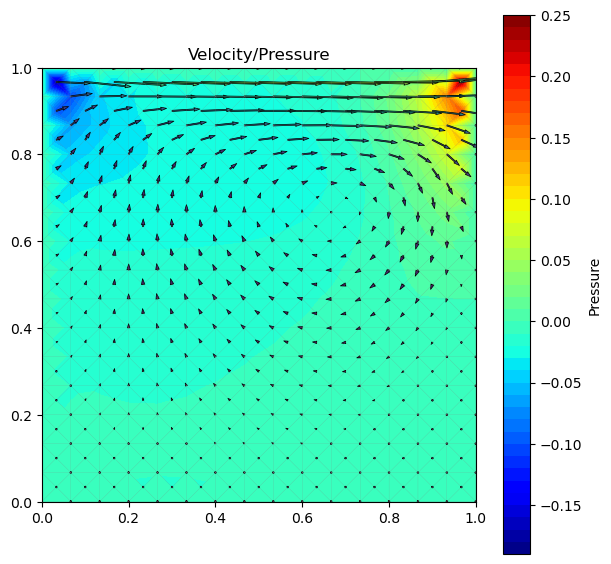

In [256]:
# Plot results
import matplotlib.pyplot as plt

# print(p_next.compute_vertex_values(mesh))
# print(u_next.compute_vertex_values(mesh))
plt.figure(figsize=(7, 7),dpi=100)

pressure_plot = fe.plot(p_next, 
                        cmap='jet',
                        levels=50)
plt.colorbar(pressure_plot, label='Pressure')
velocity_plot = fe.plot(u_next, 
                        edgecolor='black',
                        linewidth=0.5, 
                        minshaft=1, 
                        minlength=1.5,
                        title='Velocity/Pressure')
fe.plot(mesh, linewidth=0.1)
plt.show()

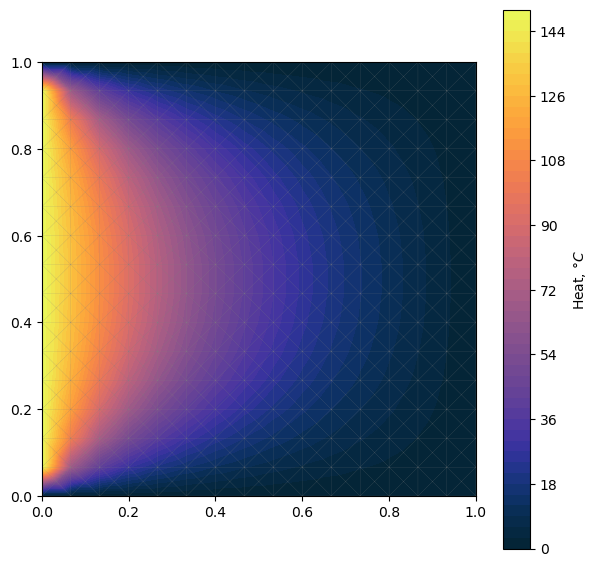

In [259]:
# Plot heat
import cmocean

plt.figure(figsize=(7, 7), dpi=100)
heat_plot = fe.plot(
    t_next, 
    cmap=cmocean.cm.thermal, # or coolwarm
    levels=50)
plt.colorbar(heat_plot, label='Heat, $\degree C$',)
fe.plot(mesh, linewidth=0.1)
plt.show()

Object cannot be plotted directly, projecting to piecewise linears.


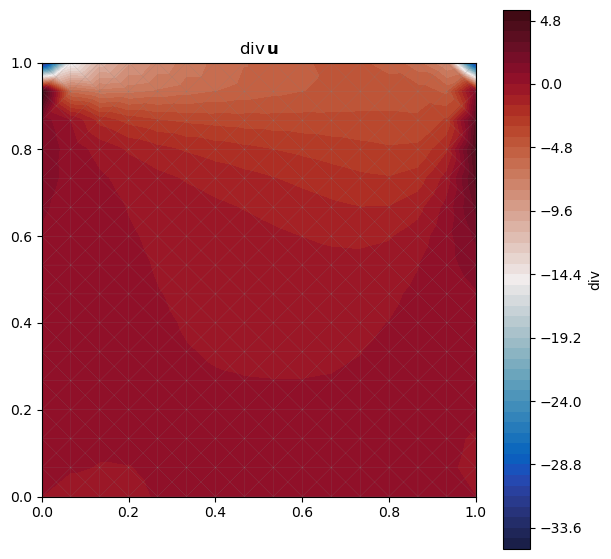

In [258]:
# Plot divergence
import cmocean

plt.figure(figsize=(7, 7), dpi=100)
curl_plot = fe.plot(fe.curl(u_next), 
                    cmap=cmocean.cm.balance,
                    levels=50,
                    title='$\operatorname{div} \mathbf{u}$')
plt.colorbar(curl_plot, label='div',)
fe.plot(mesh, linewidth=0.1)
plt.show()